# Multi Resolution Simulation

### Classes and modules

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
import datetime
from IPython.display import display
import copy

#For plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"

plt.rcParams["image.origin"] = "lower"

GPU Ocean-modules:

In [2]:
from gpuocean.utils import IPythonMagic, NetCDFInitialization

In [3]:
%cuda_context_handler gpu_ctx

In [4]:
%cuda_context_handler gpu_ctx_refined

## Selecting loc

As initial and boundary conditions to the simulation, we use data from the Norkyst800 s-level files:

In [5]:
nk800_url  = ["/sintef/data/NorKyst800/ocean_his.an.20190716.nc"]

data_args = NetCDFInitialization.removeMetadata(NetCDFInitialization.getInitialConditionsNorKystCases(nk800_url, "lofoten", download_data=False, norkyst_data=False))
data_args.keys()

dict_keys(['nx', 'ny', 'dx', 'dy', 'g', 'r', 'H', 'eta0', 'hu0', 'hv0', 'angle', 'latitude', 'f', 'boundary_conditions_data', 'boundary_conditions', 'wind'])

In [6]:
sim_args = {
    "dt": 0.0,
    "write_netcdf":False,
    "model_time_step": 60
     }

In [7]:
pert_args = {
    "small_scale_perturbation" : True,
    "small_scale_perturbation_interpolation_factor" : 21,
    "small_scale_perturbation_amplitude" : 0.00025
}

## Simulation

In [8]:
from gpuocean.SWEsimulators import CDKLM16

sim = CDKLM16.CDKLM16(gpu_ctx, **sim_args, **data_args, **pert_args)

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


In [9]:
sim.step(3600)

3600.0

### Refined Simulation

Defining local area

In [10]:
# [[y0,x0],[y1,x1]]
loc = [[100, 100], [200,300]]

scale = 1.0

Extract local IC

In [11]:
sim.give_birth(gpu_ctx_refined, loc, scale)

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


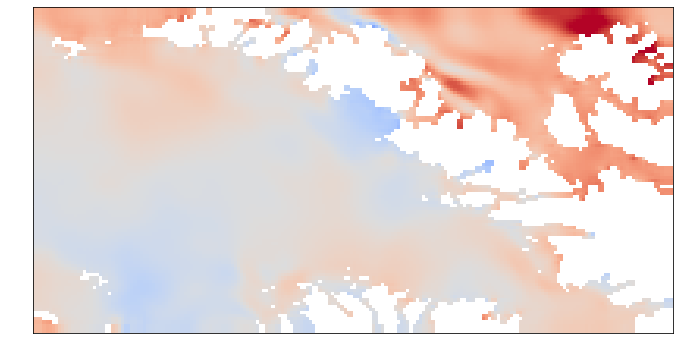

In [12]:
eta, hu, hv = sim.children[0].download()

fig, ax = plt.subplots(1,1, figsize=(12,6))
ax.imshow(eta, origin="lower", vmin=-1, vmax=1, cmap="coolwarm")

### Time evolution

In [13]:
sim.step(3600)

7200.0

## Sampling multi-resolution noise

### Sampling noise on finest level

In [14]:
pert_dx, pert_dy = 400, 400
pert_NX = np.ceil((sim.nx+4) * sim.dx/pert_dx).astype(np.int32)
pert_NY = np.ceil((sim.ny+4) * sim.dy/pert_dy).astype(np.int32)

In [15]:
import pycuda.driver as cuda
stream = cuda.Stream()

from gpuocean.SWEsimulators import Simulator, OceanStateNoise

from importlib import reload
reload(OceanStateNoise)

small_scale_model_error = OceanStateNoise.OceanStateNoise(gpu_ctx, stream, pert_NX, pert_NY, pert_dx, pert_dy, 
                                                            sim.boundary_conditions, staggered=False, soar_q0=pert_args["small_scale_perturbation_amplitude"], interpolation_factor=21, 
                                                            angle=Simulator.Simulator.get_texture(sim, "angle_tex"), 
                                                            coriolis_f=Simulator.Simulator.get_texture(sim, "coriolis_f_tex"))

In [16]:
small_scale_model_error.generateNormalDistribution()

In [17]:
small_scale_model_error.soarKernel.prepared_async_call(small_scale_model_error.global_size_SOAR, small_scale_model_error.local_size, small_scale_model_error.gpu_stream,
                                    small_scale_model_error.coarse_nx, small_scale_model_error.coarse_ny,
                                    small_scale_model_error.coarse_dx, small_scale_model_error.coarse_dy,

                                    np.float32(small_scale_model_error.soar_q0), small_scale_model_error.soar_L,
                                    np.float32(1.0),
                                    
                                    small_scale_model_error.periodicNorthSouth, small_scale_model_error.periodicEastWest,
                                    small_scale_model_error.random_numbers.data.gpudata, small_scale_model_error.random_numbers.pitch,
                                    small_scale_model_error.coarse_buffer.data.gpudata, small_scale_model_error.coarse_buffer.pitch,
                                    np.int32(0))

In [18]:
small_scale_model_error.bicubicInterpolationEtaKernel = small_scale_model_error.kernels.get_function("bicubicInterpolationEta")
small_scale_model_error.bicubicInterpolationEtaKernel.prepare("iiffiiffPiPi")

In [19]:
from gpuocean.utils import Common
eta_pert = Common.CUDAArray2D(stream, pert_NX, pert_NY, 0,0, np.zeros((pert_NY, pert_NX)))


In [20]:
small_scale_model_error.bicubicInterpolationEtaKernel.prepared_async_call(small_scale_model_error.global_size_geo_balance, small_scale_model_error.local_size, small_scale_model_error.gpu_stream,
                                                                small_scale_model_error.nx, small_scale_model_error.ny, 
                                                                small_scale_model_error.dx, small_scale_model_error.dy,
                                                                
                                                                small_scale_model_error.coarse_nx, small_scale_model_error.coarse_ny,
                                                                small_scale_model_error.coarse_dx, small_scale_model_error.coarse_dy,
                                                                
                                                                small_scale_model_error.coarse_buffer.data.gpudata, small_scale_model_error.coarse_buffer.pitch,
                                                                eta_pert.data.gpudata, eta_pert.pitch)

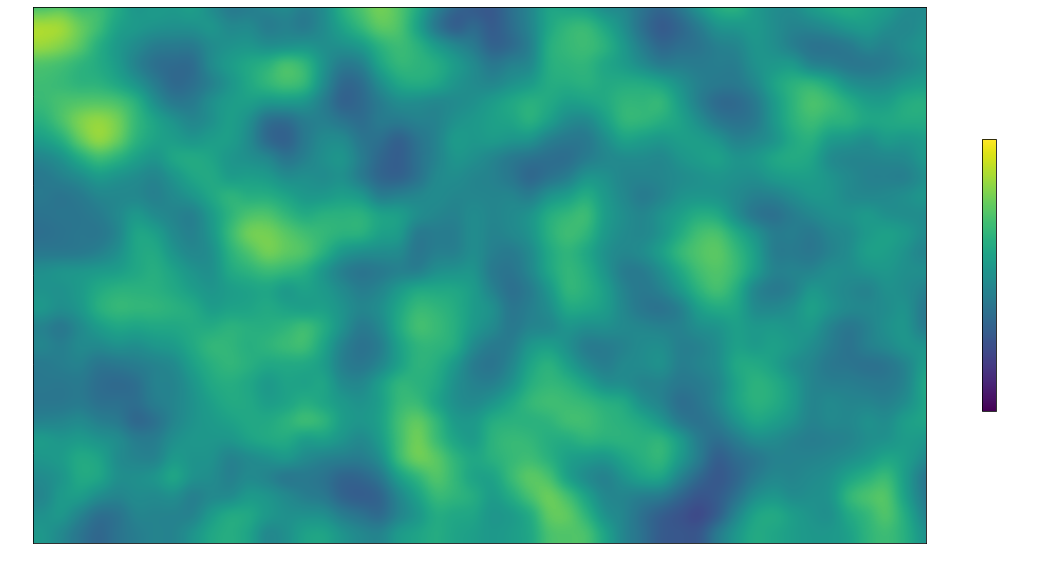

In [21]:
fig, axs = plt.subplots(1,1, figsize=(20,10))
im = axs.imshow(eta_pert.data.get(), vmin=-0.0025, vmax=0.0025, origin="lower")
# im = axs.imshow(np.roll(eta_pert.data.get(), -2, axis=1))
plt.colorbar(im, ax=axs, shrink=0.5)


### Projecting `eta_pert` to child and Child and so on

In [22]:
from scipy import interpolate 

In [23]:
x0 = np.linspace(0.5*pert_dx, (pert_NX-0.5)*pert_dx, pert_NX)
y0 = np.linspace(0.5*pert_dy, (pert_NY-0.5)*pert_dy, pert_NY)
interp = interpolate.interp2d(x0, y0, eta_pert.download(small_scale_model_error.gpu_stream), kind="linear")

In [24]:
global_local_area_x = sim.global_local_area[1][1] - sim.global_local_area[0][1]
global_local_area_y = sim.global_local_area[1][0] - sim.global_local_area[0][0]

x1 = np.linspace((sim.global_local_area[0][1]/(global_local_area_x/(sim.nx+4)) + 0.5)*sim.dx, (sim.global_local_area[1][1]/(global_local_area_x/(sim.nx+4)) - 0.5)*sim.dx, sim.nx+4)
y1 = np.linspace((sim.global_local_area[0][0]/(global_local_area_y/(sim.ny+4)) + 0.5)*sim.dy, (sim.global_local_area[1][0]/(global_local_area_y/(sim.ny+4)) - 0.5)*sim.dy, sim.ny+4)

parent_eta_pertHOST = interp(x1,y1)

In [25]:
global_local_area_x = sim.children[0].global_local_area[1][1] - sim.children[0].global_local_area[0][1]
global_local_area_y = sim.children[0].global_local_area[1][0] - sim.children[0].global_local_area[0][0]

x1 = np.linspace((sim.children[0].global_local_area[0][1]/(global_local_area_x/(sim.children[0].nx+4)) + 0.5)*sim.children[0].dx, (sim.children[0].global_local_area[1][1]/(global_local_area_x/(sim.children[0].nx+4)) - 0.5)*sim.children[0].dx, sim.children[0].nx+4)
y1 = np.linspace((sim.children[0].global_local_area[0][0]/(global_local_area_y/(sim.children[0].ny+4)) + 0.5)*sim.children[0].dy, (sim.children[0].global_local_area[1][0]/(global_local_area_y/(sim.children[0].ny+4)) - 0.5)*sim.children[0].dy, sim.children[0].ny+4)

child_eta_pertHOST = interp(x1,y1)

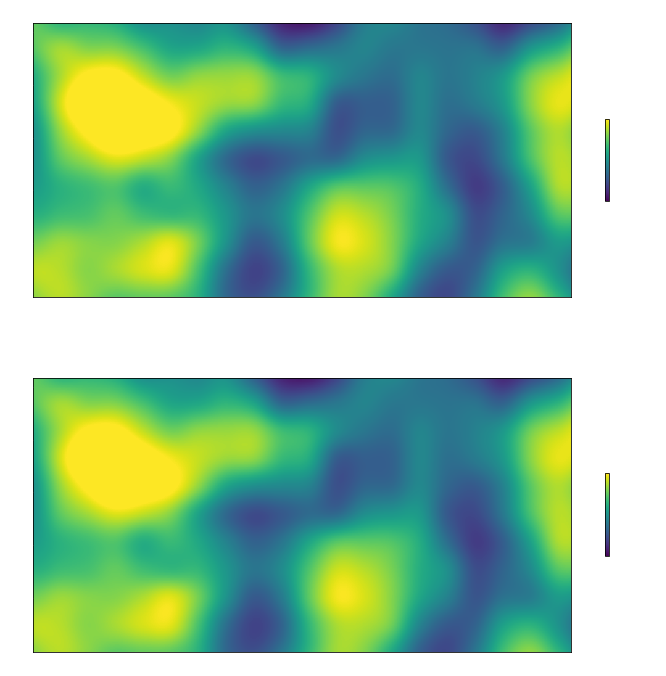

In [26]:
fig, axs = plt.subplots(2,1, figsize=(10,10))

im = axs[0].imshow(parent_eta_pertHOST[ loc[0][0] : loc[1][0]+4, loc[0][1] : loc[1][1]+4], vmin=-0.001, vmax=0.001)
axs[0].set_title("eta noise")
plt.colorbar(im, ax=axs[0], shrink=0.25)

im = axs[1].imshow(child_eta_pertHOST, vmin=-0.001, vmax=0.001)
axs[1].set_title("eta noise")
plt.colorbar(im, ax=axs[1], shrink=0.25)

plt.tight_layout()

### Geostrophic balance on each level: parent

In [27]:
parent_eta, parent_hu, parent_hv = sim.download()

In [28]:
from gpuocean.utils import Common
parent_eta_pert = Common.CUDAArray2D(stream, sim.nx, sim.ny, 2, 2, np.float32(parent_eta_pertHOST))

In [29]:
small_scale_model_error.geostrophicBalanceKernel.prepared_async_call(small_scale_model_error.global_size_geo_balance, small_scale_model_error.local_size, stream,
                                                              np.int32(sim.nx), np.int32(sim.ny),
                                                              np.int32(sim.dx), np.int32(sim.dy),
                                                              np.int32(2.0), np.int32(2.0),

                                                              np.float32(sim.g), np.float32(0.0), np.float32(0.0), np.float32(0.0),

                                                              parent_eta_pert.data.gpudata, parent_eta_pert.pitch,

                                                              sim.gpu_data.h0.data.gpudata, sim.gpu_data.h0.pitch,
                                                              sim.gpu_data.hu0.data.gpudata, sim.gpu_data.hu0.pitch,
                                                              sim.gpu_data.hv0.data.gpudata, sim.gpu_data.hv0.pitch,
                                                              
                                                              sim.bathymetry.Bi.data.gpudata, sim.bathymetry.Bi.pitch,
                                                              sim.bathymetry.mask_value)

In [30]:
loc = sim.global_local_area

In [31]:
parent_pert_eta, parent_pert_hu, parent_pert_hv = sim.download()

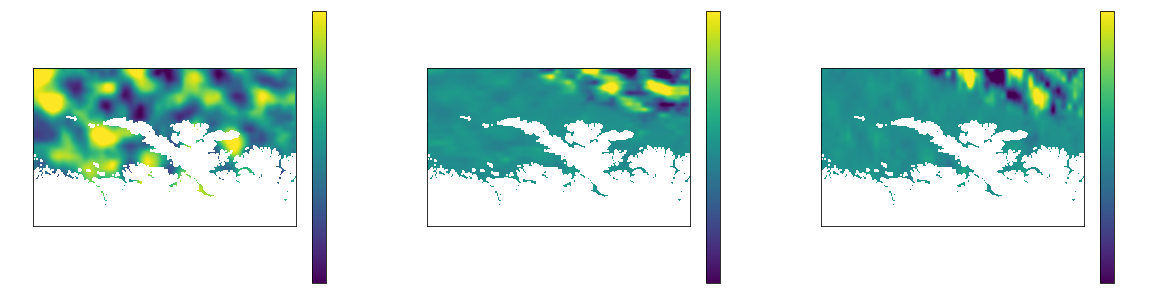

In [32]:
fig, axs = plt.subplots(1,3, figsize=(20,10))

im = axs[0].imshow(parent_pert_eta-parent_eta, vmin=-0.001, vmax=0.001)
axs[0].set_title("eta noise")
plt.colorbar(im, ax=axs[0], shrink=0.5)

im = axs[1].imshow(parent_pert_hu-parent_hu, vmin=-10, vmax=10)
axs[1].set_title("hu noise")
plt.colorbar(im, ax=axs[1], shrink=0.5)

im = axs[2].imshow(parent_pert_hv-parent_hv, vmin=-10, vmax=10)
axs[2].set_title("hv noise")
plt.colorbar(im, ax=axs[2], shrink=0.5)

### Geostrophic balance on each level: Child

In [33]:
child_eta, child_hu, child_hv = sim.children[0].download()

In [34]:
from gpuocean.utils import Common
child_eta_pert = Common.CUDAArray2D(stream, sim.children[0].nx, sim.children[0].ny, 2, 2, np.float32(child_eta_pertHOST))

In [35]:
small_scale_model_error.geostrophicBalanceKernel.prepared_async_call(small_scale_model_error.global_size_geo_balance, small_scale_model_error.local_size, stream,
                                                              np.int32(sim.children[0].nx), np.int32(sim.children[0].ny),
                                                              np.int32(sim.children[0].dx), np.int32(sim.children[0].dy),
                                                              np.int32(2), np.int32(2),

                                                              np.float32(sim.g), np.float32(0.0), np.float32(0.0), np.float32(0.0),

                                                              child_eta_pert.data.gpudata, child_eta_pert.pitch,

                                                              sim.children[0].gpu_data.h0.data.gpudata, sim.children[0].gpu_data.h0.pitch,
                                                              sim.children[0].gpu_data.hu0.data.gpudata, sim.children[0].gpu_data.hu0.pitch,
                                                              sim.children[0].gpu_data.hv0.data.gpudata, sim.children[0].gpu_data.hv0.pitch,
                                                              
                                                              sim.children[0].bathymetry.Bi.data.gpudata, sim.children[0].bathymetry.Bi.pitch,
                                                              sim.children[0].bathymetry.mask_value)

In [36]:
child_pert_eta, child_pert_hu, child_pert_hv = sim.children[0].download()

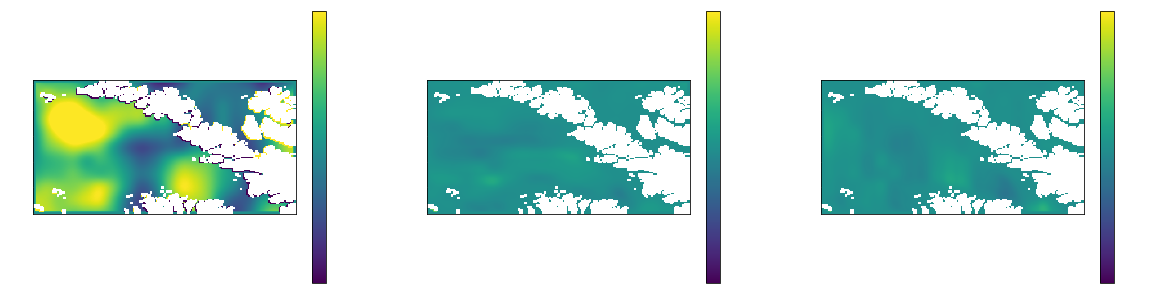

In [37]:
fig, axs = plt.subplots(1,3, figsize=(20,10))

im = axs[0].imshow(child_pert_eta-child_eta, vmin=-0.001, vmax=0.001)
axs[0].set_title("eta noise")
plt.colorbar(im, ax=axs[0], shrink=0.5)

im = axs[1].imshow(child_pert_hu-child_hu, vmin=-10, vmax=10)
axs[1].set_title("hu noise")
plt.colorbar(im, ax=axs[1], shrink=0.5)

im = axs[2].imshow(child_pert_hv-child_hv, vmin=-10, vmax=10)
axs[2].set_title("hv noise")
plt.colorbar(im, ax=axs[2], shrink=0.5)

#### Coarse vs Fine Comparion

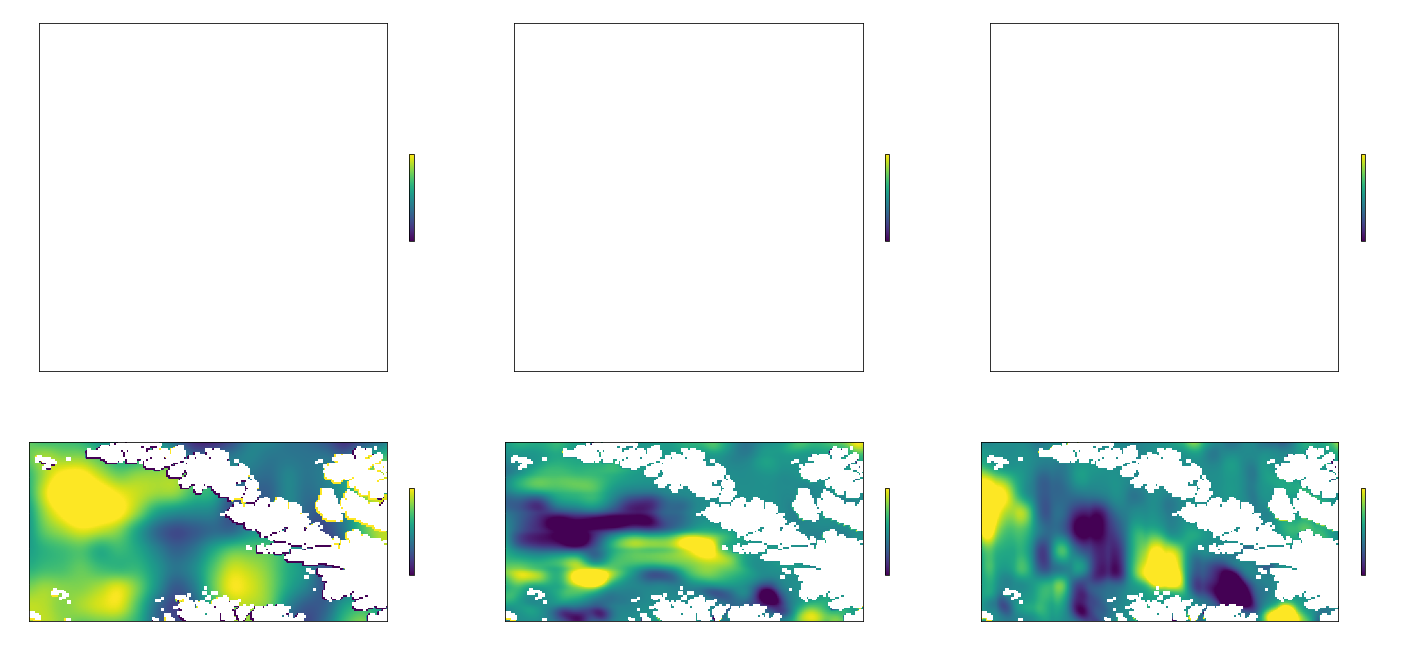

In [38]:
fig, axs = plt.subplots(2,3, figsize=(20,10))


im = axs[0,0].imshow((parent_pert_eta-parent_eta)[ loc[0][0]+2 : loc[1][0]+2, loc[0][1]+2 : loc[1][1]+2], vmin=-0.001, vmax=0.001)
axs[0,0].set_title("eta noise")
plt.colorbar(im, ax=axs[0,0], shrink=0.25)

im = axs[0,1].imshow((parent_pert_hu-parent_hu)[ loc[0][0]+2 : loc[1][0]+2, loc[0][1]+2 : loc[1][1]+2], vmin=-1, vmax=1)
axs[0,1].set_title("hu noise")
plt.colorbar(im, ax=axs[0,1], shrink=0.25)

im = axs[0,2].imshow((parent_pert_hv-parent_hv)[ loc[0][0]+2 : loc[1][0]+2, loc[0][1]+2 : loc[1][1]+2], vmin=-1, vmax=1)
axs[0,2].set_title("hv noise")
plt.colorbar(im, ax=axs[0,2], shrink=0.25)



im = axs[1,0].imshow((child_pert_eta-child_eta)[2:-2,2:-2], vmin=-0.001, vmax=0.001)
axs[1,0].set_title("eta noise")
plt.colorbar(im, ax=axs[1,0], shrink=0.25)

im = axs[1,1].imshow((child_pert_hu-child_hu)[2:-2,2:-2], vmin=-1, vmax=1)
axs[1,1].set_title("hu noise")
plt.colorbar(im, ax=axs[1,1], shrink=0.25)

im = axs[1,2].imshow((child_pert_hv-child_hv)[2:-2,2:-2], vmin=-1, vmax=1)
axs[1,2].set_title("hv noise")
plt.colorbar(im, ax=axs[1,2], shrink=0.25)

plt.tight_layout()

If one of the cells intersections is dry, `eta` is reset to 0 - and the `Bi` of the child simulation is a bit broader than the other.

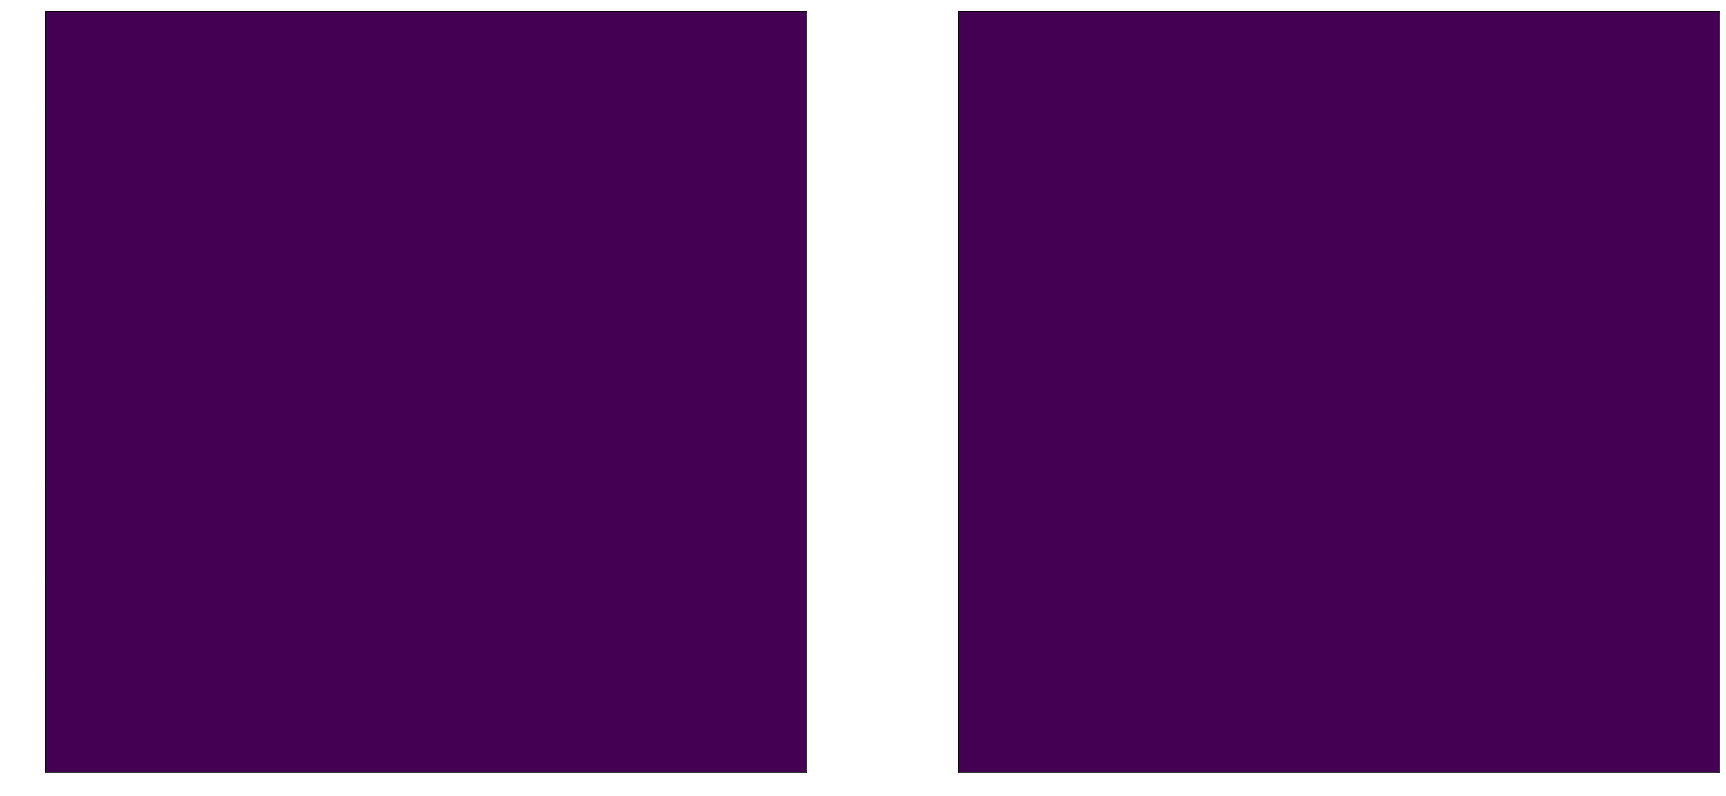

In [39]:
fig, axs = plt.subplots(1,2,figsize=(30,15))
# plt.imshow(sim.download()[0][ loc[0][0]+2 : loc[1][0]+2, loc[0][1]+2 : loc[1][1]+2])
axs[0].imshow((sim.bathymetry.Bi.download(sim.gpu_stream)[ loc[0][0]+2 : loc[1][0]+3, loc[0][1]+2 : loc[1][1]+3] == 1e20).astype(float))
axs[1].imshow(parent_eta.mask[ loc[0][0]+2 : loc[1][0]+2, loc[0][1]+2 : loc[1][1]+2].astype(float))

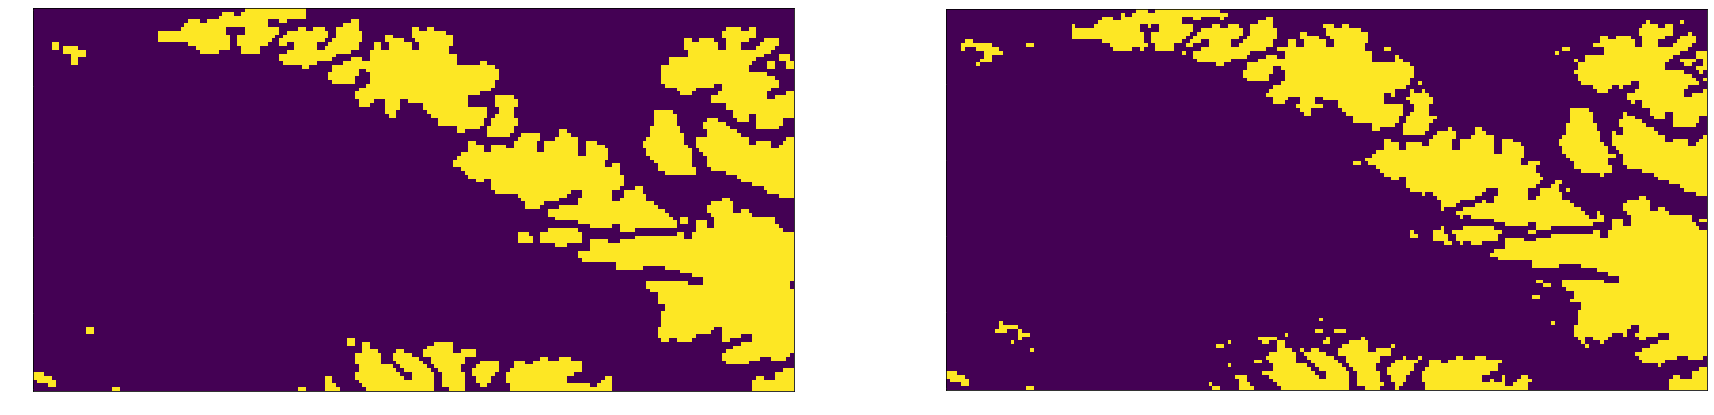

In [40]:
fig, axs = plt.subplots(1,2,figsize=(30,15))
# plt.imshow(sim.download()[0][ loc[0][0]+2 : loc[1][0]+2, loc[0][1]+2 : loc[1][1]+2])
axs[0].imshow((sim.children[0].bathymetry.Bi.download(sim.gpu_stream)[2:-2,2:-2] == 1e20).astype(float))
axs[1].imshow(child_eta.mask[2:-2,2:-2].astype(float))